# Starter Notebook

Install and import required libraries

In [1]:
!pip install transformers datasets evaluate accelerate peft trl bitsandbytes
!pip install nvidia-ml-py3


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
!pip install matplotlib

In [2]:
import os
import pandas as pd
import torch
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, Dataset, ClassLabel
import pickle

In [ ]:
# Import necessary libraries first
import os
import pandas as pd
import torch
import torch.nn as nn
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification, RobertaConfig
from peft import LoraConfig, get_peft_model, PeftModel, TaskType
from datasets import load_dataset, Dataset, ClassLabel
import pickle
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load and prepare dataset (keeping your original code)
base_model = 'roberta-base'
dataset = load_dataset('ag_news', split='train')#Loads the training split of the AG News dataset using the Hugging Face Datasets library.
tokenizer = RobertaTokenizer.from_pretrained(base_model)

def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding=True)
    return tokenized
# Defines a preprocessing function:
# Tokenizes the text field of the dataset.
# Ensures the sequences are truncated to a max length and padded to a uniform length.

tokenized_dataset = dataset.map(preprocess, batched=True, remove_columns=["text"])
# Applies the preprocess function to the entire dataset in batches.
# Removes the original text column (only keeping the tokenized version).
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
# Renames the label column to labels, which is the expected format for Hugging Face models.

# Extract class info
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")
id2label = {i: label for i, label in enumerate(class_names)}
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

# Create a custom configuration with increased dropout
onfig = RobertaConfig.from_pretrained(
    base_model,
    num_labels=num_labels,
    id2label=id2label,# Mapping from label IDs to label names.
    hidden_dropout_prob=0.07,#7% of the hidden layer activations will be randomly set to zero during training only.
)

# Load model with custom configuration
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    config=config
)

# Create a custom model class with additional dropout layers
class EnhancedRobertaClassifier(nn.Module):
    def __init__(self, roberta_model):
        super().__init__()
        self.roberta = roberta_model
        # Additional dropout before classification layer
        self.extra_dropout = nn.Dropout(0.1)
        
    def forward(self, **inputs):
        outputs = self.roberta(**inputs)
        # Apply extra dropout to pooled output before classification
        if hasattr(outputs, 'logits'):
            # For sequence classification models
            return outputs
        # For base models that don't have classification head
        pooled_output = outputs.pooler_output
        pooled_output = self.extra_dropout(pooled_output)
        # Return modified outputs
        outputs.pooler_output = pooled_output
        return outputs
#Above function Takes a roberta_model (base or classification).
# During the forward pass:
# If the model already has a classification head (has .logits), it returns the output directly.
# If not, it applies additional dropout (0.1) to the pooler_output before returning it (for custom classification logic later).
# So it's mainly used to add regularization to base models and handle both base + classification variants clean

# Split the original training set
split_datasets = tokenized_dataset.train_test_split(test_size=640, seed=42)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']

# Metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# PEFT Config
peft_config = LoraConfig(
    r=12,
    lora_alpha=32,
    lora_dropout=0.06,
    bias='none',
    target_modules=["roberta.encoder.layer.0.attention.self.query",
    "roberta.encoder.layer.0.attention.self.key",
    "roberta.encoder.layer.0.attention.self.value",
    "roberta.encoder.layer.1.attention.self.query",
    "roberta.encoder.layer.5.attention.self.query",
    "roberta.encoder.layer.10.attention.self.query",
    "roberta.encoder.layer.10.output.dense",
    "roberta.encoder.layer.11.output.dense"],
    task_type="SEQ_CLS",
)
# Parameter         | Meaning
# r=12              | Rank of the low-rank update matrices (smaller r → fewer trainable params)
# lora_alpha=32     | Scaling factor for the LoRA update (helps with stability)
# lora_dropout=0.06 | Dropout applied to the LoRA layers (to prevent overfitting)
# bias='none'       | Don’t fine-tune bias terms of the original model
# task_type='SEQ_CLS' | Sequence classification task (like AG News)
# Makes fine-tuning efficient and lightweight for the AG News classification task.

# Apply PEFT to the model
print("Applying PEFT adapters to the model...")
peft_model = get_peft_model(model, peft_config)
print("PEFT Model Configuration:")
peft_model.print_trainable_parameters()

# Enhanced Training Arguments
print("Defining Training Arguments...")
training_args = TrainingArguments(
    output_dir="./results_lora_enhanced_dropout",
    learning_rate=3e-4, # Higher LR is safe here since only LoRA adapters are trained (base model is frozen)
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=6,             
    weight_decay=0.1,
    eval_strategy="epoch",         
    save_strategy="epoch",
    load_best_model_at_end=True,#Automatically load best model after training
    push_to_hub=False,
    logging_dir='./logs_lora_enhanced_dropout',
    logging_steps=100,
    report_to="none",
    warmup_ratio=0.15, #Warm up 15% of steps before applying full LR             
    # bf16=True,                    
    gradient_accumulation_steps=2,  
    lr_scheduler_type="cosine",   #	Use cosine decay for learning rate  
    metric_for_best_model="accuracy",
)

# Initialize Trainer
print("Initializing Trainer...")
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Train the model
result = trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']
Applying PEFT adapters to the model...


/tmp/ipykernel_5920/162166440.py:133: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


PEFT Model Configuration:
trainable params: 796,420 || all params: 125,445,128 || trainable%: 0.6349
Defining Training Arguments...
Initializing Trainer...


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/home/rp4216/.local/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.226200,0.229881,0.923438,0.923165,0.923624,0.923438
2,0.205300,0.212387,0.932813,0.932785,0.933655,0.932813
3,0.179100,0.189831,0.934375,0.934367,0.934621,0.934375
4,0.162200,0.188529,0.935937,0.935998,0.937456,0.935937
5,0.155800,0.184070,0.935937,0.935954,0.937016,0.935937
6,0.142100,0.185267,0.939063,0.939090,0.939983,0.939063


/home/rp4216/.local/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/rp4216/.local/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/rp4216/.local/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/rp4216/.local/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/rp4216/.local/lib/python3.9/site-packages/torch/nn/parallel/_f

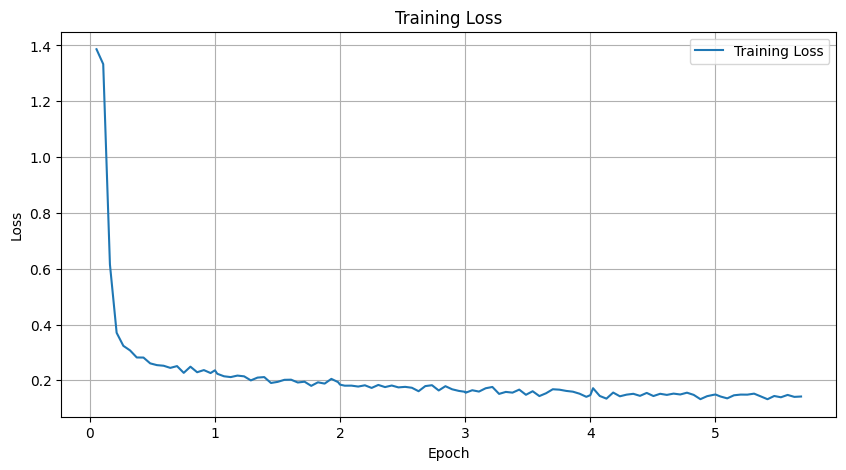

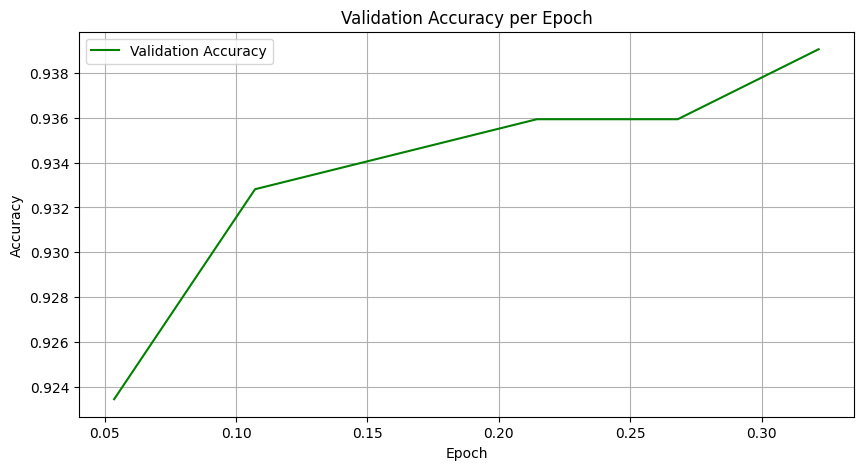

In [18]:
import matplotlib.pyplot as plt

# Extract metrics from trainer log history
logs = trainer.state.log_history

# Initialize lists to store data
epochs, train_loss, val_loss, val_acc = [], [], [], []

# Populate the lists
for log in logs:
    if 'epoch' in log:
        epochs.append(log['epoch'])
        if 'loss' in log:
            train_loss.append(log['loss'])
        if 'eval_loss' in log:
            val_loss.append(log['eval_loss'])
        if 'eval_accuracy' in log:
            val_acc.append(log['eval_accuracy'])

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs[:len(train_loss)], train_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs[:len(val_acc)], val_acc, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()


## Load Tokenizer and Preprocess Data

## Anything from here on can be modified

## Evaluate Finetuned Model


### Performing Inference on Custom Input
Uncomment following functions for running inference on custom inputs

In [11]:
def classify(model, tokenizer, text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt").to(device)
    output = model(**inputs)

    prediction = output.logits.argmax(dim=-1).item()

    print(f'\n Class: {prediction}, Label: {id2label[prediction]}, Text: {text}')
    return id2label[prediction]

In [12]:
classify( peft_model, tokenizer, "Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...")
classify( peft_model, tokenizer, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.")


 Class: 1, Label: Sports, Text: Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...

 Class: 2, Label: Business, Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindlinand of ultra-cynics, are seeing green again.


'Business'

### Run Inference on eval_dataset

In [13]:
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm

def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.

    Args:
        inference_model: The model to evaluate.
        dataset: The dataset (Hugging Face Dataset) to run inference on.
        labelled (bool): If True, the dataset includes labels and metrics will be computed.
                         If False, only predictions will be returned.
        batch_size (int): Batch size for inference.
        data_collator: Function to collate batches. If None, the default collate_fn is used.

    Returns:
        If labelled is True, returns a tuple (metrics, predictions)
        If labelled is False, returns the predictions.
    """
    # Create the DataLoader
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    if labelled:
        metric = evaluate.load('accuracy')

    # Loop over the DataLoader
    for batch in tqdm(eval_dataloader):
        # Move each tensor in the batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions.append(predictions.cpu())

        if labelled:
            # Expecting that labels are provided under the "labels" key.
            references = batch["labels"]
            metric.add_batch(
                predictions=predictions.cpu().numpy(),
                references=references.cpu().numpy()
            )

    # Concatenate predictions from all batches
    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        eval_metric = metric.compute()
        print("Evaluation Metric:", eval_metric)
        return eval_metric, all_predictions
    else:
        return all_predictions

In [14]:
# Check evaluation accuracy
_, _ = evaluate_model(peft_model, eval_dataset, True, 8, data_collator)

100%|██████████| 80/80 [00:02<00:00, 27.23it/s]

Evaluation Metric: {'accuracy': 0.9390625}


### Run Inference on unlabelled dataset

In [15]:
#Load your unlabelled data
unlabelled_dataset = pd.read_pickle("test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])
unlabelled_dataset

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 8000
})

In [16]:
# Define the output directory
output_dir = "./results_lora_enhanced_dropout"

# Run inference and save predictions
preds = evaluate_model(peft_model, test_dataset, False, 8, data_collator)
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # or preds.tolist()
})

# Save predictions to the CSV file
df_output.to_csv(os.path.join(output_dir, "inference_output.csv"), index=False)
print("Inference complete. Predictions saved to inference_output.csv")


100%|██████████| 1000/1000 [00:28<00:00, 35.41it/s]

Inference complete. Predictions saved to inference_output.csv
